<a href="https://colab.research.google.com/github/sleepless-se/Colab/blob/master/open_cv_remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw


def get_gradation_2d(start, stop, width, height, is_horizontal):
    if is_horizontal:
        return np.tile(np.linspace(start, stop, width), (height, 1))
    else:
        return np.tile(np.linspace(start, stop, height), (width, 1)).T
def get_gradation_3d(width, height, start_list, stop_list, is_horizontal_list):
    result = np.zeros((height, width, len(start_list)), dtype=np.float)

    for i, (start, stop, is_horizontal) in enumerate(zip(start_list, stop_list, is_horizontal_list)):
        result[:, :, i] = get_gradation_2d(start, stop, width, height, is_horizontal)
    return result

def nparray_to_rgb(nparry:np.array):
  return (int(nparry[0]),int(nparry[1]),int(nparry[2]))
  
def find_edge(img_path:str):
  img = cv2.imread(img_path,0)
  blur = cv2.blur(img,(5,5))
  edges = cv2.Canny(blur,100,200)
  return edges

def find_target(edges): 
  results = np.where(edges==255)
  top = np.min(results[0])
  bottom = np.max(results[0])
  left = np.min(results[1])
  right = np.max(results[1])
  return (left,top,right,bottom)

def to_RGB(image:Image):
  if image.mode == 'RGB': return image
  background = Image.new("RGB", image.size, (255, 255, 255))
  background.paste(image, mask=image.split()[3])  # 3 is the alpha channel
  background.format = image.format
  return background

def open_rgb(image_path: str):
    im = Image.open(image_path)
    im = to_RGB(im)
    return im

def get_median_color(img:Image,px):
  array = np.array(img)
  median = np.median(array,axis=1)
  return median[px]

def get_around(img_path):
  edges = find_edge(img_path)
  left,top,right,bottom = find_target(edges)
  return (left,top,right,bottom)

def average_np(array:list):
  array = np.array(array)
  array = np.average(array,axis=0)
  return (int(array[0]),int(array[1]),int(array[2]))

def get_xy_center(around:list):
  x = around[0] + around[2]
  y = around[1] + around[3]
  return int(x/2),int(y/2)

def get_width(around:list):
  return around[2] - around[0]

def get_height(around:list):
  return around[3] - around[1]

def get_longer(around):
  longer = get_width(around)
  height = get_height(around)
  if longer < height:longer = height
  return longer

def make_background(top_color,bottom_color,img_size):
  print('top_color',top_color)
  print('bottom_color',bottom_color)

  bg_top_color = average_np(top_color)
  bg_bottom_color = average_np(bottom_color)

  print('bg_top_color',bg_top_color)
  print('bg_bottom_color',bg_bottom_color)

  array = get_gradation_3d(
      img_size,img_size, 
      nparray_to_rgb(bg_top_color), 
      nparray_to_rgb(bg_bottom_color),
      (False, False, False)
  )
  bg = Image.fromarray(np.uint8(array))
  return bg

def get_img_infos(img_paths:list):
  rgb_imgs, around, top_color,bottom_color = [],[],[],[]

  for i in range(len(img_paths)):
    around.append(get_around(img_paths[i]))
    rgb_imgs.append(open_rgb(img_paths[i]))

    # find top and bottomo color
    top_color.append(get_median_color(rgb_imgs[i],around[i][1]))
    bottom_color.append(get_median_color(rgb_imgs[i],around[i][3]))
    
  return rgb_imgs, around, top_color,bottom_color

def get_pre_shift(img_size ,terget_area, object_area):
  terget_area = np.array(terget_area)
  terget_center = np.mean(terget_area,axis=0)

  object_area = np.array(object_area)
  object_center = np.mean(object_area,axis=0)

  pre_shift = terget_center - object_center
  
  print('terget_area',terget_area)
  print('object_area',object_area)
  print('terget_center',terget_center)
  print('object_center',object_center)
  print('pre_shift',pre_shift)
  
  return pre_shift

def get_shift(img_size ,terget_area, object_area):
  print('- - get_shift - -')
  pre_shift = get_pre_shift(img_size ,terget_area, object_area)
  pre_shift = np.array(pre_shift).astype('int')
  pre_shift = tuple(pre_shift)
  print('pre_shift',pre_shift)
  return pre_shift
#   left_top_margin = object_area[0] + pre_shift

#   img_size = np.array(img_size)
#   print('object_area[1:2]',object_area[1:2])
#   right_bottom_margin = img_size - object_area[1:2]
#   print('right_bottom_margin',right_bottom_margin)
#   right_bottom_margin = right_bottom_margin + pre_shift

#   fix_shift = np.array([left_top_margin.tolist(),right_bottom_margin[0].tolist()])

#   fix_shift = np.where(fix_shift<0,fix_shift,0)
#   fix_shift = np.min(fix_shift,axis=0) # 0 or 1 ?
#   x = pre_shift[0] - fix_shift[0]
#   y = pre_shift[1] - fix_shift[1]

  print('img_size',img_size)
  
  print('left_top_margin',left_top_margin)
  print('right_bottom_margin',right_bottom_margin)
  print('fix_shift',fix_shift)
  print('x,y',int(x),int(y))
  print('- - end get_shift - -')
  return (int(x),int(y))

def draw_rectangle(source_img,around):
  print('around',around)
  draw = ImageDraw.Draw(source_img)
  draw.rectangle(around, outline='black')
  source_img.save('./out.jpg', "JPEG")

def get_rate(layout_width:int,layout_height:int,around:list):
  width = get_width(around)
  height = get_height(around)
  print('width:height',width,height)

  rate_x = layout_width / width
  rate_y = layout_height / height
  print('rate_x,rate_y',rate_x,rate_y)
  rate = rate_x if rate_x < rate_y else rate_y
  print('rate',rate)
  return rate

def get_1_1_split(rgb_imgs, around, img_size):
  x_shift,y_shift,shift_to,masks = [],[],[],[]
  # resize
  half_img_size = int(img_size/2)
  for i in range(len(img_paths)):
    rate = get_rate(half_img_size,img_size,around[i])

    object_area = np.array(around[i]) * rate
    object_area = object_area.reshape(2,2)

    new_width = int(rgb_imgs[i].size[0] * rate)
    new_height = int(rgb_imgs[i].size[1] * rate)
    print('new_width:new_height',new_width,new_height)
    
    rgb_imgs[i].thumbnail((new_width,new_height), Image.ANTIALIAS)
    print('image {}:{}'.format(i,rgb_imgs[i].size))

    height = img_size - rgb_imgs[i].size[1]
    print('height',height)
    width = int(object_area[0][0])
    print('width',width)

    if i == 0:
      terget_area = [(0,0),(half_img_size,img_size)]
#       draw_rectangle(rgb_imgs[i],tuple(map(tuple, object_area)))
      shift_to.append(get_shift(img_size,terget_area,object_area))

    if i == 1:

      terget_area = [(half_img_size,0),(img_size,img_size)]
      shift_to.append(get_shift(img_size,terget_area,object_area))

      # make mask
      mask = Image.new("L", rgb_imgs[i].size, 0)
      draw2 = ImageDraw.Draw(mask)
      right_max = half_img_size + rgb_imgs[i].size[0] - img_size
      print('right_max',right_max)
      if right_max < width:width = right_max
      draw2.rectangle((width, 0, rgb_imgs[i].size), fill=255)
      masks.append(mask)

    x_shift.append(width)
    y_shift.append(height)
  # paste
#   bg.paste(rgb_imgs[0],(shift_to[0]))
#   bg.paste(rgb_imgs[1],(shift_to[1]),masks[0])
#   return bg
  return rgb_imgs,shift_to,masks

width:height 1769 671
rate_x,rate_y 0.14132278123233466 0.7451564828614009
rate 0.14132278123233466
new_width:new_height 307 392
image 0:(307, 391)
height 109
width 28
- - get_shift - -
terget_area [[  0   0]
 [250 500]]
object_area [[ 28.40587903 229.79084228]
 [278.40587903 324.61842849]]
terget_center [125. 250.]
object_center [153.40587903 277.20463539]
pre_shift [-28.40587903 -27.20463539]
pre_shift (-28, -27)
width:height 1724 2337
rate_x,rate_y 0.14501160092807425 0.2139495079161318
rate 0.14501160092807425
new_width:new_height 315 402
image 1:(315, 402)
height 98
width 40
- - get_shift - -
terget_area [[250   0]
 [500 500]]
object_area [[ 40.74825986   0.        ]
 [290.74825986 338.89211137]]
terget_center [375. 250.]
object_center [165.74825986 169.44605568]
pre_shift [209.25174014  80.55394432]
pre_shift (209, 80)
right_max 65
top_color [array([236., 236., 236.]), array([220., 220., 224.])]
bottom_color [array([231., 231., 231.]), array([224., 224., 226.])]
bg_top_color (228

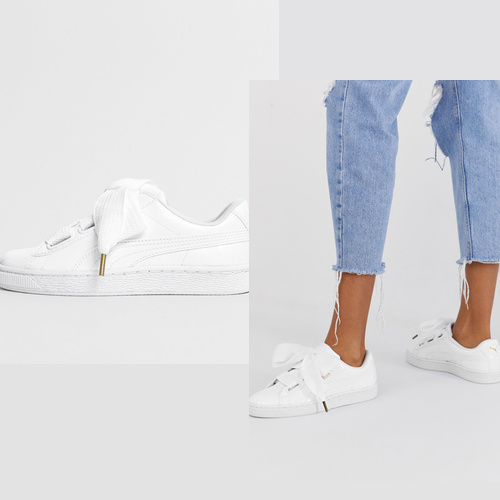

In [22]:
img_size = 500
img_paths = ['/content/asos.png','/content/asos1.png']
img_paths = ['/content/10571310/a01.jpg','/content/asos1.png']
img_paths = ['/content/11269717/a01.jpg','/content/11269717/a02.jpg']
# img_paths = ['/content/a01.jpg','/content/a03.jpg']

rgb_imgs, around, top_color, bottom_color = get_img_infos(img_paths)

rgb_imgs,shift_to,masks = get_1_1_split(rgb_imgs, around,img_size)

bg = make_background(top_color, bottom_color, img_size)


bg.paste(rgb_imgs[0],(shift_to[0]))
bg.paste(rgb_imgs[1],(shift_to[1]),masks[0])
bg
# plt.imshow(bg)
# plt.plot()


In [17]:
Image.open('/content/8934106/a03.jpg')

FileNotFoundError: ignored

In [0]:
!unzip test_image.zip

In [0]:
object_area = [ 157.12290503 , 129.18994413, 1407.12290503, 2266.06145251]
object_area = np.array(object_area)
object_area.reshape(2,2)

In [0]:
import os
for cur,dirs,files in os.walk('/content/test_image'):
  print(cur)
  print(dirs)
  print(files)

In [0]:
!unzip middle_sample.zip

In [0]:
!ls

In [0]:



img_size = [500,500]
terget_area = [(0,0),(250,500)]
object_area = [(100,200),(400,500)]

shift_to = get_shift(img_size ,terget_area, object_area)
print('shift_to',shift_to)
print(' - - - ')
img_size = [500,500]
terget_area = [(250,0),(500,500)]
object_area = [(100,200),(300,450)]

shift_to = get_shift(img_size ,terget_area, object_area)
print('shift_to',shift_to)


In [0]:
img_size = np.array(img_size)
img_size - object_area[1:2]
(int(pre_shift[0] - fix_shift[0]),int(pre_shift[1] + fix_shift[1]))

In [0]:
if img_center[0] < terget_center[0]:print("right has speace")
if img_center[] < terget_center[0]:print("left has speace")

In [0]:
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

rgb_imgs, around, top_color,bottom_color = get_img_infos(img_paths)


  
draw_rectangle(rgb_imgs[0],around[0])



In [0]:
type(left_top.tolist())

In [0]:
[left_top.tolist(),right_bottom.tolist()]